# Public Transit for the City of Detroit
### CMSE202, Section 001, Group 007
### Tiffany Rennells, Marco Abat, Brendan Hunt, Matthew Gagea

### Abstract:
Public transportation is typically a staple part of a quality-of-life assessment of a major city. Detroit is unique in this sense due to the fact that much of its economy and function revolves around automobiles. This reliance perservered, even when the automobile industry slowly started to leave the city, resulting in the gradual loss of over 150,000 industry jobs. This came to a peak in 2013 when Detroit became the largest city ever to declare bankruptcy in the United States (1). Fortunately, since then, the Detroit economy has been on a steady incline. Transportation-related infrastructure for the metro-detroit area, however, has been consistently mediocre. Outside of the bus systems, there is a single elevated rail system that makes rounds within the detroit area. The consequences of this lacking transportation system have been felt; In 2016, there were 24.7% of households in the metro Detroit area that lacked a car. This is much higher than the national average of 8.7% per city (2). Our project aims to offer a solution to the current shortcomings of the Detroit public transportation network: By calculating population densities across designated census tracts, plotting nodes in communities that are in need of transportation, and connecting these nodes using different algorithms, we have designed a subway system that is accessible to both Detroit and its surrounding suburbs.

In [9]:
#import statements
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import random
import networkx as nx
from scipy.spatial import distance
import numpy as np
from scipy.spatial import distance_matrix
from collections import defaultdict
import heapq
import math

In [3]:
#Importing data, column names are in file "variable_names.txt"
gdf = gpd.read_file("datasets")
gdf.head()

,spatial_id,name,VALUE0,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,geometry
0,261635001001,"BG5001001, Wayne County, MI",4.2169,NaN,0.0000,96.0843,400.0,399.0,33.0,399.0,51251.365072,1250.0,"POLYGON ((-82.95600 42.44286, -82.95589 42.442..."
1,261635001002,"BG5001002, Wayne County, MI",9.9465,0.0000,3.2086,84.2781,1309.0,861.0,98.0,861.0,40171.750323,2162.0,"POLYGON ((-82.95621 42.45005, -82.95606 42.450..."
2,261635002001,"BG5002001, Wayne County, MI",0.0000,0.0000,0.0000,99.8016,476.0,446.0,0.0,446.0,75163.830814,1004.0,"POLYGON ((-82.97221 42.44341, -82.97158 42.444..."
3,261635002002,"BG5002002, Wayne County, MI",13.7255,9.3514,0.0000,76.9231,830.0,776.0,0.0,776.0,41981.004966,1649.0,"POLYGON ((-82.96609 42.44989, -82.96494 42.449..."
4,261635003001,"BG5003001, Wayne County, MI",3.7736,0.0000,0.0000,96.2264,780.0,410.0,47.0,410.0,41183.777026,817.0,"POLYGON ((-82.97711 42.43596, -82.97690 42.436..."


Text(36.597222222222214, 0.5, 'Longitude')

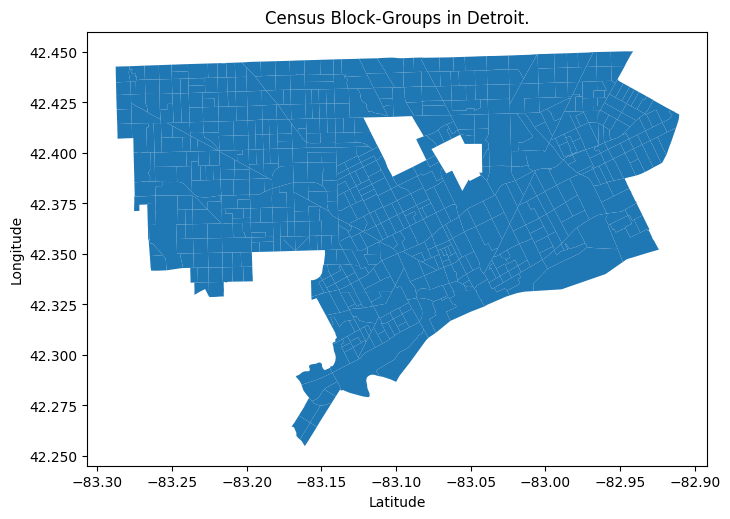

In [4]:
#Plotting a map of blockgroups in Detroit.
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(ax=ax)
plt.title("Census Block-Groups in Detroit.")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

### Superblocks

As per our parameter of serving all populations of the City of Detroit, we first set out to group areas of the city together to create locations for stops. We decide to use population as our parameter. To create these areas, we group together adjacent block groups to create larger geographical and population areas, what we refer to as "superblocks". Each of these superblocks will have one train stop assigned to it and will by extension have one line running through it.

In [5]:
def find_adjacent_blocks(block, gdf):
    """
    Finds blocks adjacent to the given block.
    
    Parameters:
    - block: The GeoDataFrame row of the current block.
    - gdf: The entire GeoDataFrame of blocks.
    
    Returns:
    - A GeoDataFrame of adjacent blocks.
    """
    # Use the touches method to find blocks that share a boundary with the current block
    adjacent = gdf[gdf.geometry.touches(block.geometry)]
    return adjacent

def group_blocks(gdf, target_population, margin=1000):
    """
    
    Groups blocks into supergroups based on adjacency and population criteria.
    
    Parameters:
    - gdf: GeoDataFrame containing all blocks with their population.
    - target_population: The target population for each group.
    - margin: The margin of error for the target population.
    
    Returns:
    - A list of GeoDataFrames, each representing a grouped superblock.
    """
    grouped_blocks = []
    visited = set()
    
    for index, block in gdf.iterrows():
        if index in visited:
            continue
        
        current_group = [block]
        current_population = block['VALUE9']
        queue = [block]
        visited.add(index)
        
        while queue:
            current_block = queue.pop(0)
            if current_population >= target_population - margin and current_population <= target_population + margin:
                break
            
            adjacents = find_adjacent_blocks(current_block, gdf)
            
            for _, adj_block in adjacents.iterrows():
                adj_index = adj_block.name
                if adj_index not in visited and current_population + adj_block['VALUE9'] <= target_population + margin:
                    visited.add(adj_index)
                    current_group.append(adj_block)
                    current_population += adj_block['VALUE9']
                    queue.append(adj_block)
        
        if current_group:
            grouped_blocks.append(gpd.GeoDataFrame(current_group))
    
    return grouped_blocks

In [6]:
#Call group_blocks function
target_population = 19000
margin = 2000
supergroups = group_blocks(gdf, target_population, margin)
len(supergroups)

42

/tmp/ipykernel_699771/2362820943.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(supergroups))


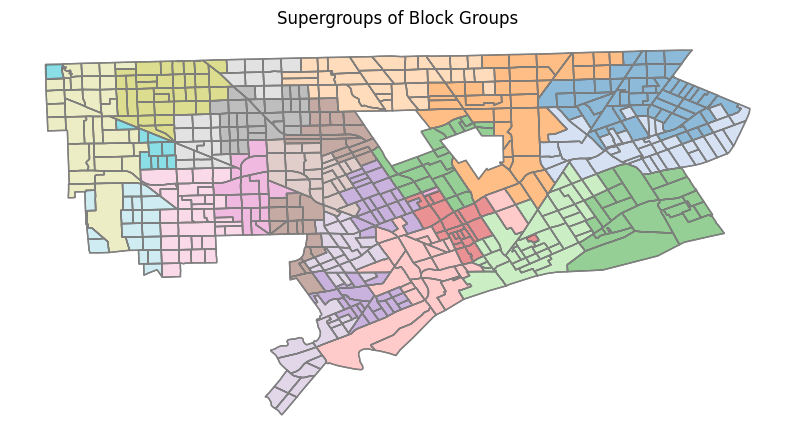

In [7]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')
colors = plt.cm.get_cmap('tab20', len(supergroups)) 
for i, group in enumerate(supergroups):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)
ax.set_title('Supergroups of Block Groups')
ax.set_axis_off()  

plt.show()

In [8]:
import folium

center = gdf.geometry.centroid.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=12)
import random

for i, group in enumerate(supergroups):
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    
    geojson = folium.GeoJson(
        group.geometry.to_json(),
        name=f"Group {i+1}",
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
        }
    ).add_to(m)
    
    geojson.add_child(folium.Popup(f"Group {i+1}"))

folium.LayerControl().add_to(m)
m

/tmp/ipykernel_699771/586753238.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf.geometry.centroid.unary_union.centroid


## Getting the Train Stops

/tmp/ipykernel_699771/1999899968.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(supergroups))


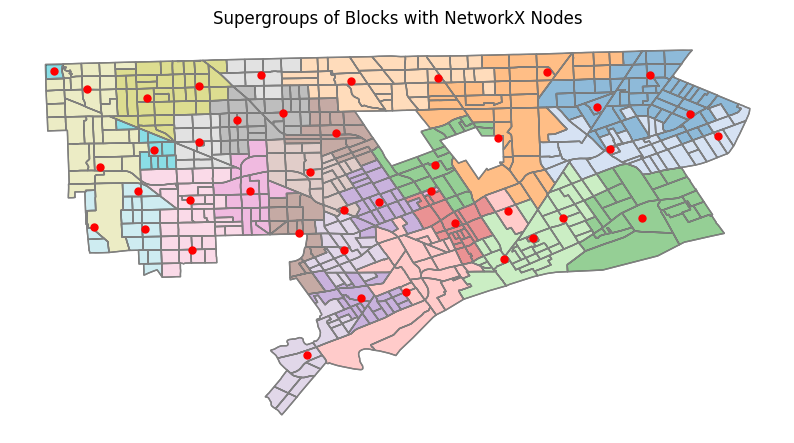

In [10]:
gdf = gpd.read_file("datasets")
target_population = 19000
margin = 2000
supergroups = group_blocks(gdf, target_population, margin)
G = nx.Graph()
pos = {}
for i, group in enumerate(supergroups):
    superblock = group.unary_union
    centroid = superblock.centroid
    G.add_node(i)
    pos[i] = (centroid.x, centroid.y)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')
colors = plt.cm.get_cmap('tab20', len(supergroups))
for i, group in enumerate(supergroups):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)
ax.set_title('Supergroups of Blocks with NetworkX Nodes')
ax.set_axis_off()
for node, (x, y) in pos.items():
    ax.plot(x, y, marker='o', color='red', markersize=5)

plt.show()

In [12]:
coordinates_list = list(pos.values())
coordinates_array = np.array(coordinates_list)

In [13]:
def find_city_center(superblocks):
    x_vals = superblocks[:,0]
    y_vals = superblocks[:,1]
    x_mean = x_vals.mean()
    y_mean = y_vals.mean()
    return np.array([x_mean, y_mean])

def id_verticies(superblocks, center, no_lines):
    # Calculate distances from central coordinate
    distances = np.linalg.norm(superblocks - center, axis=1)
    
    # Sort distances and get indices of n furthest coordinates
    furthest_indices = np.argsort(distances)[-no_lines*2:]
    
    # Extract the furthest coordinates
    furthest_coords = superblocks[furthest_indices]
    
    return furthest_coords

def assign_verticies(verticies):
    all_pairs = list(combinations(verticies, 2))

    # Sort pairs by distance
    sorted_pairs = sorted(all_pairs, key=lambda pair: np.linalg.norm(pair[0] - pair[1]), reverse=True)
    
    # Group the coordinates into pairs
    furthest_pairs = []
    paired_indices = set()
    for pair in sorted_pairs:
        idx1 = np.where((verticies == pair[0]).all(axis=1))[0][0]
        idx2 = np.where((verticies == pair[1]).all(axis=1))[0][0]
        if idx1 not in paired_indices and idx2 not in paired_indices:
            furthest_pairs.append(pair)
            paired_indices.add(idx1)
            paired_indices.add(idx2)
    
    return furthest_pairs

#COMBINATIONS TAKEN FROM PYTHON DOCUMENTATION
def combinations(iterable, r):
    # combinations('ABCD', 2) → AB AC AD BC BD CD
    # combinations(range(4), 3) → 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

#Calculates the length of one line. Helper method to get_lowest_mean. 
def pythagerize(cords):
    total_len = 0
    for i in range(0, len(cords)-1, 1):
        x1, y1 = cords[i]
        x2, y2 = cords[i + 1]
        app_len = math.sqrt((x2-x1)**2 + (y2-y1)**2)
        total_len += app_len
    return total_len
    
def get_lowest_mean(combos, term):
    #concatenate the starting and terminal node onto combinations
    route_len = float('inf')
    best_route = []
    for i in range(0, len(combos), 1):
        #unpack from tuple
        inner_pts = list(combos[i])
        test_pts = [term[0]]
        for j in inner_pts:
            test_pts.append(j)
        test_pts.append(term[1])
        test_len = pythagerize(test_pts)
        if (test_len < route_len):
            route_len = test_len
            best_route = test_pts
    return route_len, best_route

def remove_pts(data, to_remove):
    for i in to_remove:
        if (i in data):
            data.remove(i)
    return data

#Creates best train system given parameters.
def create_lines(data_lt, tup):
    best_system = []
    system_len = 0
    n=0
    while(len(data_lt) > 0):
        combos = list(combinations(data_lt, 5))
        terminicies = (tup[n], tup[n+1])
        add_len, add_route = get_lowest_mean(combos, terminicies)
        best_system.append(add_route)
        system_len += add_len
        data_lt = remove_pts(data_lt, add_route)
        n+=2
    return system_len, best_system

def compare_lines(best_len, new_len, best_system, new_system):
    #Returns whichever length/system is shorter.
    pass

In [18]:
data = coordinates_array
no_trains = 6
cen = find_city_center(data)
cords = id_verticies(data, cen, no_trains)
pairs = assign_verticies(cords)

#Extracts terminals from 2D array and puts them into a 1D list.
extract = []
for i in pairs:
    extract.append(i[0])
    extract.append(i[1])

#Changes data from a np.array() to a list.
data_list = []
for i in range(0, len(data), 1):
    data_list.append(data[i,:])

#Converts data into tuple dtype.
tup = [tuple(arr) for arr in extract]
data_lt = [tuple(arr) for arr in data_list]

#Removes terminals from the inner points.
data_lt = remove_pts(data_lt, tup)


train_lines = create_lines(data_lt, tup)

## Plotting the Train Lines

In [19]:
# Storing the locations and coordinates in dictionary form
all_stops = {}
for lines in train_lines[1:]:
    for i in range(len(lines)):
        for j in range(len(lines[i])):
            stop_name = f"Route {i + 1} Stop {j + 1}"
            all_stops[stop_name] = lines[i][j]


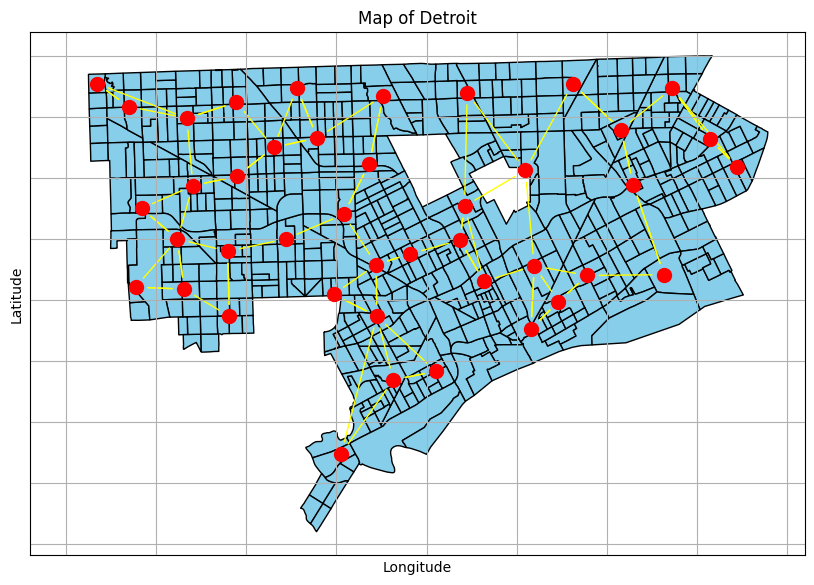

In [20]:
# Calculates the distance between two points
def distance(coord1, coord2):
    """ 
    Calculates the eucledian distance between two points

    Parameters: 
    - coords1: first coordinate
    - coords2: second coordinate

    Returns: the distance

    """
    
    x1, y1 = coord1
    x2, y2 = coord2
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


# Returns a dictionary of closest to farthest neighbors
def closest_neighbors(places_dict, target_point):

    """
    Gives a list of the closest neighbours from a reference point

    Parameters:
    - places_dict: Dictionary of locations and their coordinates
    - target_point: The location of reference

    Returns a list of places from closest to farthest from the reference point
    """

    # Initialize an empty dictionary 
    distances = {}
    
    for location, coord in places_dict.items():

        # Check that we are not comparing two of the same points
        if coord != target_point:
            
            # The location as a key and its distance as the value.
            distances[location] = distance(coord, target_point)

    # Sort distances from closest to farthest
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    
    return sorted_distances

def nodes_edges_one_train(detroit_shapefile, places_dict):

    """
    Plots nodes and edges of the train system on a map

    Parameters:
    - detroit_shapefile: the file of the map
    - places_dict: dictionary of location and their coordinates

    Returns: A map with the nodes as locations and edges going from a point to its two nearest neighbors.

    """
    # Reads the shapefile
    detroit = gpd.read_file(detroit_shapefile)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile
    detroit.plot(ax=ax, color='skyblue', edgecolor='black')

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes at specified coordinates
    for place, coords in places_dict.items():
        # Add node to the graph
        G.add_node(place, pos=coords)

    # Call the distance function to get a list of distances 
    for place, coords in places_dict.items():
        
        dist = closest_neighbors(places_dict, coords)
        
        closest1 = dist[0][0] # Name of the closest neighbor
        closest2 = dist[1][0] # Name of the second closest neighbor

        # Add edges to the two closest neighbors
        G.add_edge(place, closest1) 
        G.add_edge(place, closest2)

    # Draw nodes 
    nx.draw_networkx_nodes(G, pos=places_dict, node_size=100, ax=ax, node_color='red')

    # Draw edges 
    nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')

    # Set title, labels, and grid
    plt.title('Map of Detroit')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Display the plot
    plt.show()

# Example of places and their coordinates


# Path to shapefile
detroit_shapefile = 'datasets'

#Call the function
nodes_edges_one_train(detroit_shapefile, all_stops)

In [21]:
def nodes_edges(detroit_shapefile, places_dict, map_name):

    """
    Plots nodes and edges of the train system on a map

    Parameters:
    - detroit_shapefile: the file of the map
    - places_dict: dictionary of location and their coordinates in order of stops.

    Returns: A map with the nodes as locations and edges going from a point to the next stop as defined by the dictionary.

    """
    # Reads the shapefile
    detroit = gpd.read_file(detroit_shapefile)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile
    detroit.plot(ax=ax, color='skyblue', edgecolor='black')

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes at specified coordinates
    for place, coords in places_dict.items():
        # Add node to the graph
        G.add_node(place, pos=coords)

    # add edges from the previous stop to the next stop 
    for i in range(1, len(places_dict)):
        for j in range(1, 8): 
            current_stop = f"Route {i} Stop {j}"
            next_stop = f"Route {i} Stop {j + 1}"
            if next_stop not in places_dict:
                break  # Stop the loop if either the current or next stop is not in places_dict
            G.add_edge(current_stop, next_stop)
        
    # Draw nodes 
    nx.draw_networkx_nodes(G, pos=places_dict, node_size=100, ax=ax, node_color='red')

    
    #Draw edges
    nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')
    
    # Set title, labels, and grid
    plt.title(f'Map of {map_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Display the plot
    plt.show()

# Path to shapefile
detroit_shapefile = 'datasets'

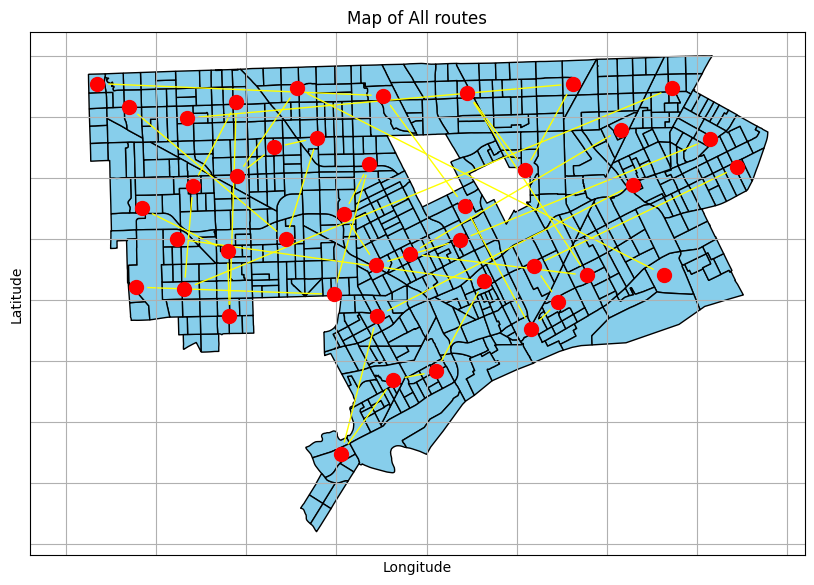

In [22]:
#Call the function
map_name = "All routes"
nodes_edges(detroit_shapefile, all_stops, map_name)

In [23]:
#Separating all routes into separate routes. 

# Initialize empty dictionary
routes = {}

# Iterate through the all_stops dictionary
for stop_name, coordinates in all_stops.items():
    
    # Extract the route number from the stop name
    route_num = stop_name.split()[1]  
    if route_num not in routes:
        routes[route_num] = {}
    routes[route_num][stop_name] = coordinates

def get_route(route_number):
    return routes.get(route_number, {})


route_1 = get_route('1')
route_2 = get_route('2')
route_3 = get_route('3')
route_4 = get_route('4')
route_5 = get_route('5')
route_6 = get_route('6')


/tmp/ipykernel_699771/53744089.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


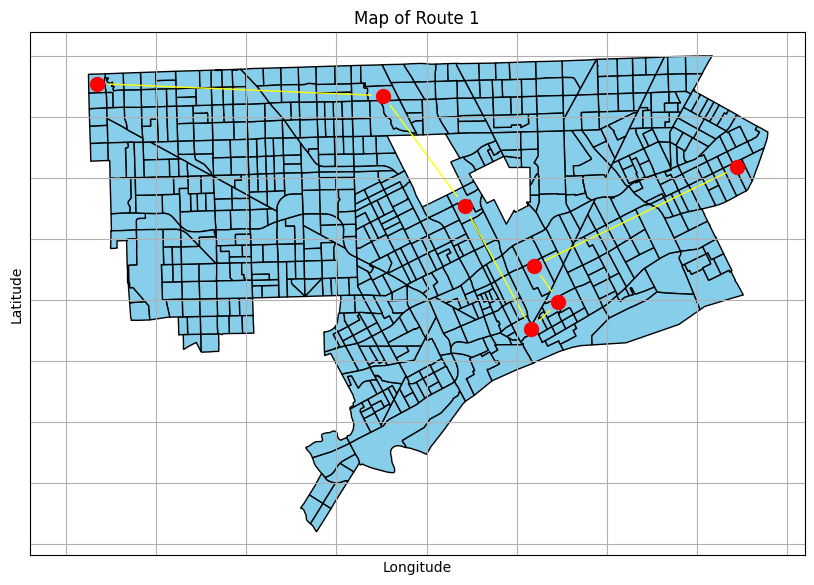

In [24]:
map_name1 = "Route 1"
nodes_edges(detroit_shapefile, route_1, map_name1)

/tmp/ipykernel_699771/53744089.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


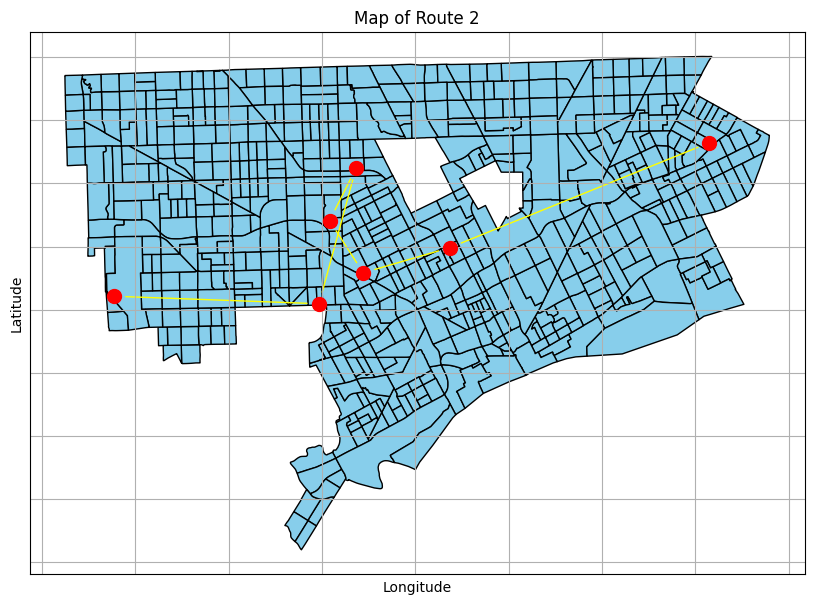

In [25]:
map_name2 = "Route 2"
nodes_edges(detroit_shapefile, route_2, map_name2)

/tmp/ipykernel_699771/53744089.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


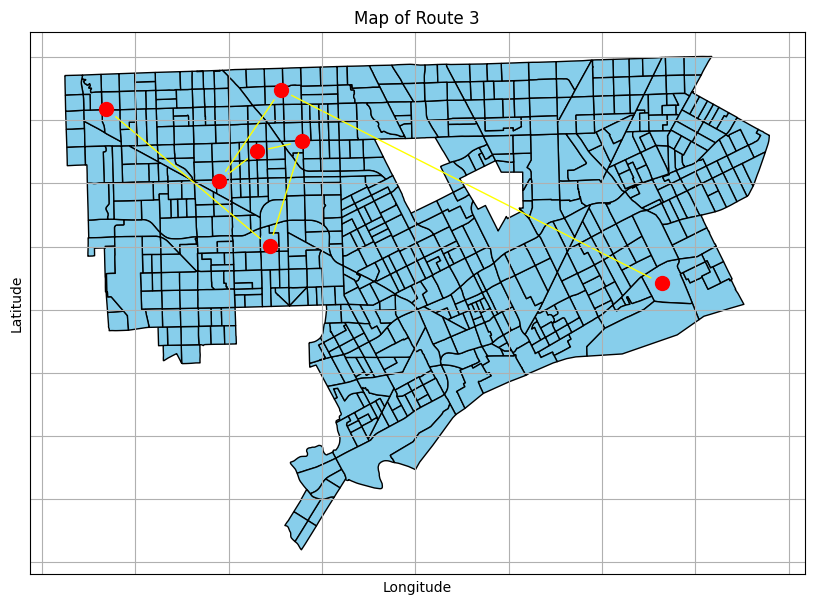

In [26]:
map_name3 = "Route 3"
nodes_edges(detroit_shapefile, route_3, map_name3)

/tmp/ipykernel_699771/53744089.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


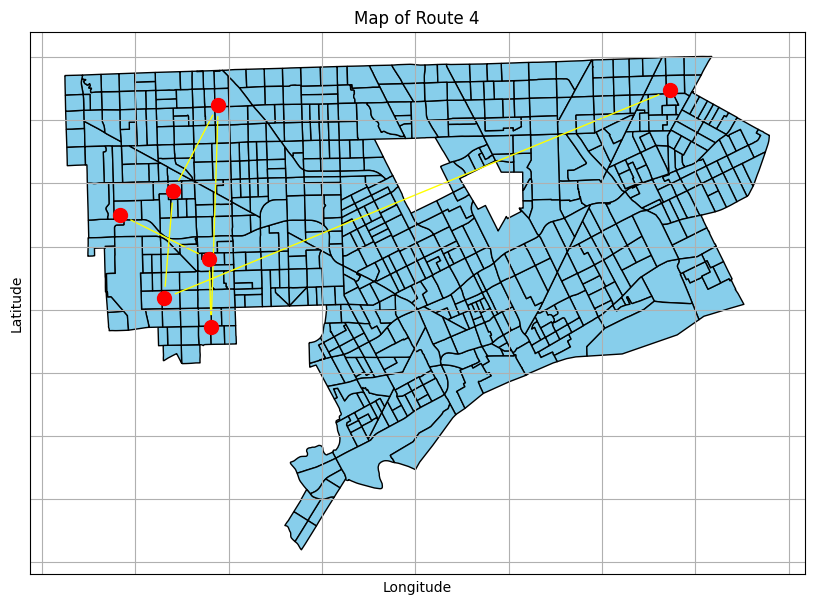

In [27]:
map_name4 = "Route 4"
nodes_edges(detroit_shapefile, route_4, map_name4)

/tmp/ipykernel_699771/53744089.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


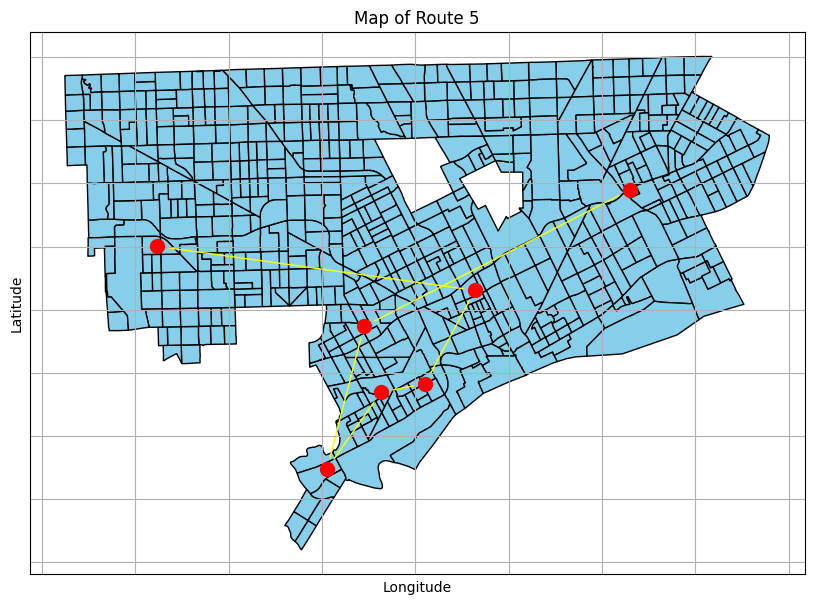

In [28]:
map_name5 = "Route 5"
nodes_edges(detroit_shapefile, route_5, map_name5)